# Predicting Newsletter Subscription with KNN Classification Using Age and Experience Level

Contributors:
- Emily Tu (90525254)
- Yifan Zuo (54090832)

Github: https://github.com/dod0bird/Dsci-Group-Project

## Introduction
Video games are widely being used for the study of human behaviour and decision making. In this project we are using data obtained from a [MineCraft Server](https://plai.cs.ubc.ca), collected by [The Pacific Laboratory for Artificial Intelligence (PLAI)](https://plai.cs.ubc.ca), a research team at UBC. The team needs to target their recruitment efforts, and make sure they have enough resources (e.g., software licenses, server hardware) to handle the number of players they attract. 

The players who join the server give consent for their in-game activities to be recorded for research purposes and have the opportunity to subscribe to a game related newsletter. The research team wants to know who is subscribing to the newsletter as subscribed players are easier to contact for future follow-up studies, improving the effectiveness of participant recruitment, and subscription behaviour may reflect a player's level of engagement with the research project, since more invested players may be more willing to remain connected and contribute additional data over time.


## Question

#### Broad question
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

#### Specific question
The question we will be exploring is "Can a player's experience level and Age predict whether they subscribe to the newsletter, using the data based on the players dataset?"

We will use the `players.csv` dataset, which has 7 variables and 196 observations, describing general demographic information about each player logged on the server:

| Variable       | Description                             | Type                  |
| -------------- | --------------------------------------- | --------------------- |
| `experience`   | The player’s level of experience        | character              |
| `subscribe`    | The player’s subscription status to the game newsletter       | logical |
| `hashedEmail`  | The player’s unique identifier code     | character             |
| `played_hours` | The player’s total number of hours each player has played on the MineCraft server. | double             |
| `name`         | The player’s name                       | character             |
| `gender`       | The player’s reported gender                     | character             |
| `Age`          | The player’s age (in years)             | double              |


There are 2 quantitative variables, their calculated means are below:

| Mean Hours Played | Mean Age |
| -------- | ------- |
| 5.85  | 21.14    |



There are a few issues with the data:
- `experience`, `subscribe`, `gender`, are read in as the incorrect data type, they should be stored as categorical variables instead.
- `Age` should be an integer.
- Variables such as `experience` and `Age` are self-reported, which may introduce accuracies or inconsistencies.

To address our specific question, `subscribe` (TRUE/FALSE) is the response variable, while `experience` (Beginner, Amateur, Regular, Veteran, Pro) and `Age` (in years) are the predictors that may influence subscription behaviour. By modelling these relationships, we can potentially identify what types of players are more likely to subscribe based on their self-reported information.

We are observing the predictors `experience` and `Age`. A player's experience may reflect how comfortable or invested a player is in gaming. More experienced players might engage more consistently, feel more connected to the research environment, or be more willing to participate in follow-up studies. Age may influence play behaviour, availability, or motivation to engage with research content. Different age groups may show different subscription patterns depending on their interests or gaming habits.

## Methods and Results

We plan to use a K-Nearest Neighbors (KNN) classification model to predict whether a player will subscribe based on their age and experience. KNN classification is a simple, intuitive algorithm. There are no specific data or shape assumptions about the data for the algorithm to perform well. 

Predictors: `Age` and `experience`  
Response variable: `subscribe`

Method:
1. Load the packages that are necessary.
2. Use the URL to load the players dataset.
3. Wrangle and clean the data:
   - Selecting the required columns and filtering out players with `played_hours` = 0, as these players may be inactive or may have registered for the game but never participated.
   - Remove any missing values because they may impact the calculations later on.
   - Convert variables to their appropriate types, (e.g. `experience` and `subscribe` to factor variables, and `Age` to integer).
   - Prepare the data by applying One-Hot Encoding to convert `experience` into a numeric variable so it can be used for classification.

For the "Data analysis" section: 
+ I'll split the dataset into training and testing sets before modeling. Specifically, I will use 70% of the data for training and 30% for testing to evaluate model performance on unseen data.
+ Within the training data, I will apply 5-fold cross-validation to tune the value of K. In each fold, 80% of the training data will be used for training and 20% will be used as the validation set.
+ After running 5-fold cross-validation for each K value, I will look at the average accuracy of each model. The model with the highest average accuracy will be selected.
+ Finally, I'll use the best k to do a fix model and evaluate for accuracy, precision, and recall.



### 1. Load required libraries
Loading the required libraries to compute our analysis

In [32]:
library(tidyverse)
library(tidymodels)
library(kknn)
set.seed(2200)

### 2. Load data
Reading the player dataset from the GitHub URL

In [33]:
url = 'https://raw.githubusercontent.com/dod0bird/Dsci-Group-Project/refs/heads/main/players.csv'
players <- read_csv(url)
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### 3. Wrangling and cleaning the data 
Selecting the required columns, filtering out inactive players, then converting variables to their appropriate types and removing any observations with missing values

In [34]:
# select the required columns and filter out players with `played_hours` = 0
players_new <- players |> 
mutate(experience = as_factor(experience),
       subscribe = as_factor(subscribe),
       Age = as.integer(Age)) |>
filter(played_hours > 0) |>
select(c(1,2,7)) 

# remove the missing values
players_new <- players_new |>
drop_na()

head(players_new)

experience,subscribe,Age
<fct>,<fct>,<int>
Pro,TRUE,9
Veteran,TRUE,17
Amateur,TRUE,21
Regular,TRUE,21
Amateur,TRUE,47
Veteran,TRUE,23


### Summary of data set after wrangling and cleaning
Viewing the levels of each categorical variable and calculating summary statistics

In [58]:
experience_categories <- players_new |>
    distinct(experience)
experience_categories

experience
<fct>
Pro
Veteran
Amateur
Regular
Beginner


In [59]:
subscribe_levels <- players_new |>
     group_by(subscribe) |>
    summarise(count = n())
subscribe_levels

subscribe,count
<fct>,<int>
FALSE,25
TRUE,84


In [60]:
subscribe_ratio <- 84 / (84 + 25)
subscribe_ratio

[1] 0.7706422

The `TRUE` class (n = 84) significantly outnumbers the `FALSE` class (n = 25), indicating a noticeable class imbalance. It is also observed that 77.06% of players are subscribed to the newsletter.

In [62]:
# Calculate summary statistics for the Age variable(mean, min, max, SD)
age_summary <- players_new |>
  summarize(age_mean = mean(Age, na.rm = TRUE),
            age_min = min(Age, na.rm = TRUE),
            age_max = max(Age, na.rm = TRUE),
            age_sd = sd(Age, na.rm = TRUE))
age_summary

age_mean,age_min,age_max,age_sd
<dbl>,<int>,<int>,<dbl>
21.30275,9,58,7.652771


In [63]:
dim(players_new)

[1] 109   3

### Players dataset overview after wrangling and cleaning:
- number of observations: 109
- number of variables: 3
  
Variables:
+ `experience` is a catagorical variable that records player's experience level in the game falling under `Pro`,`Veteran`, `Amateur`, `Regular`, or `Beginner`.
+ `subscribe` is a catagorical variable that indicates if the player is subscribed to a game-related newsletter, with `TRUE` meaning subscribed and `FALSE` meaning not subscribed.
+ `Age` is a integer variable that records the player's age in years. The mean age is 21.30 years old, with a minimum of 9 years old, a maximum of 58 years old, and a standard deviation of 7.65 years old.

## Exploratory Data Analysis and Visualization

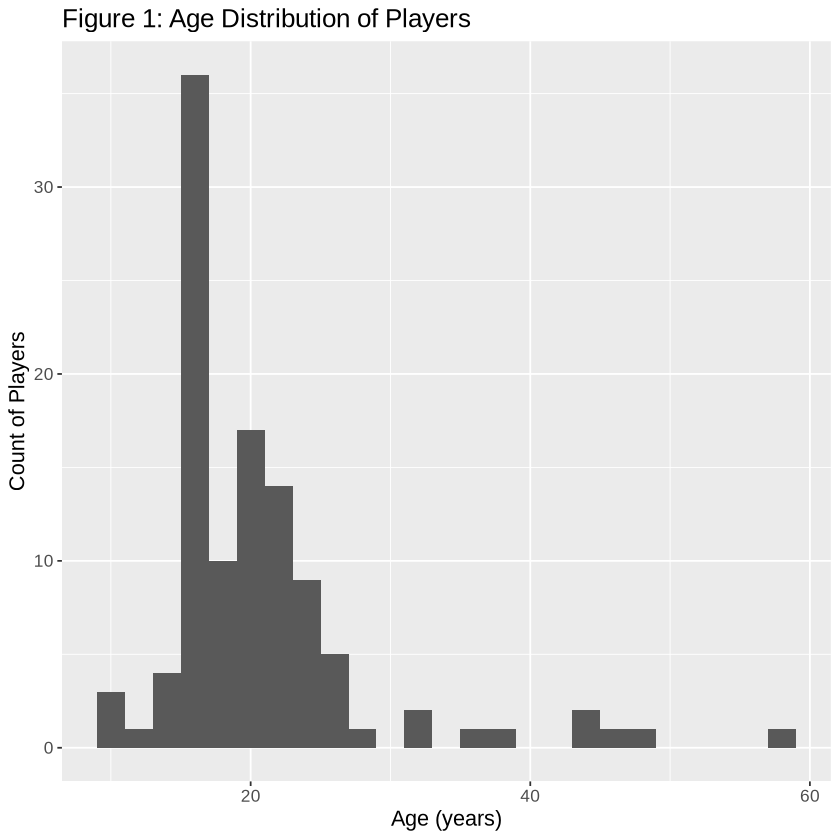

In [64]:
age_distribution <- players_new |>
  ggplot(aes(x = Age)) +
  geom_histogram(binwidth = 2) +
  xlab("Age (years)") + ylab("Count of Players") +
  ggtitle("Figure 1: Age Distribution of Players") +
  theme(text = element_text(size=13))
age_distribution

Figure 1 shows the distribution of player ages. We can observe that most players fall between 15 and 20 years old and there are few players under 15 and over 30, indicating that distribution is heavily skewed towards younger players.

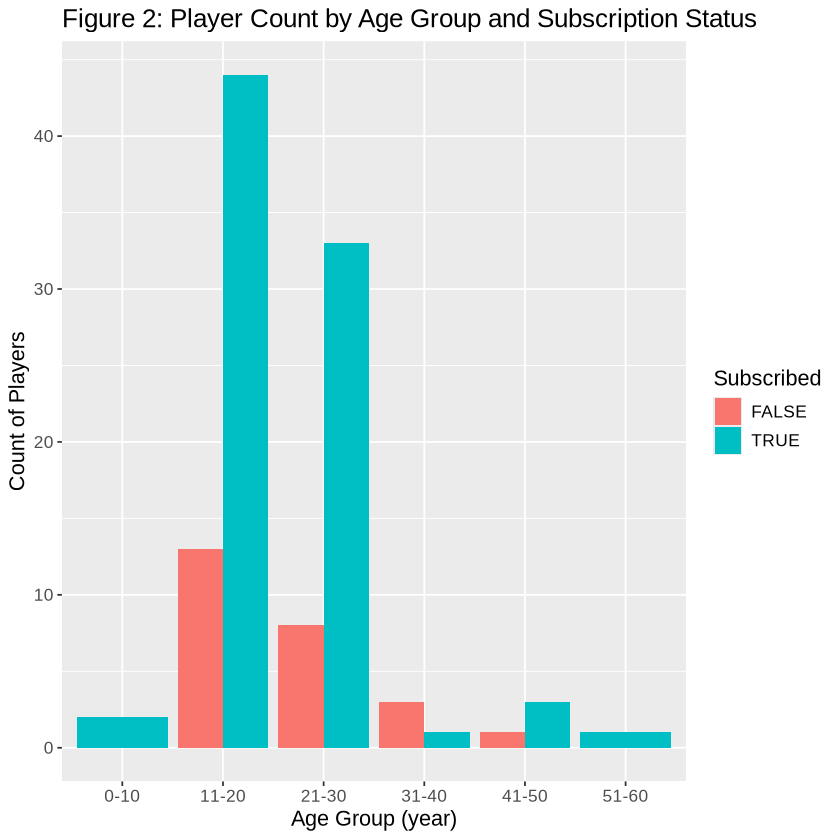

In [11]:
age_subscribe_bar <- players_new |>
  mutate(age_group = cut(Age, breaks = c(0, 10, 20, 30, 40, 50, 60),
                         labels = c("0-10", "11-20", "21-30", "31-40", "41-50", "51-60"))) |>
  ggplot(aes(x = age_group, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(x = "Age Group (year)", y = "Count of Players",
       fill = "Subscribed",
       title = "Figure 2: Player Count by Age Group and Subscription Status")+
  theme(text = element_text(size=13))

age_subscribe_bar

Figure 2 shows that people between 11 and 30 years old subscribe the most compared to other age groups. This may because there are more people playing games at this age.

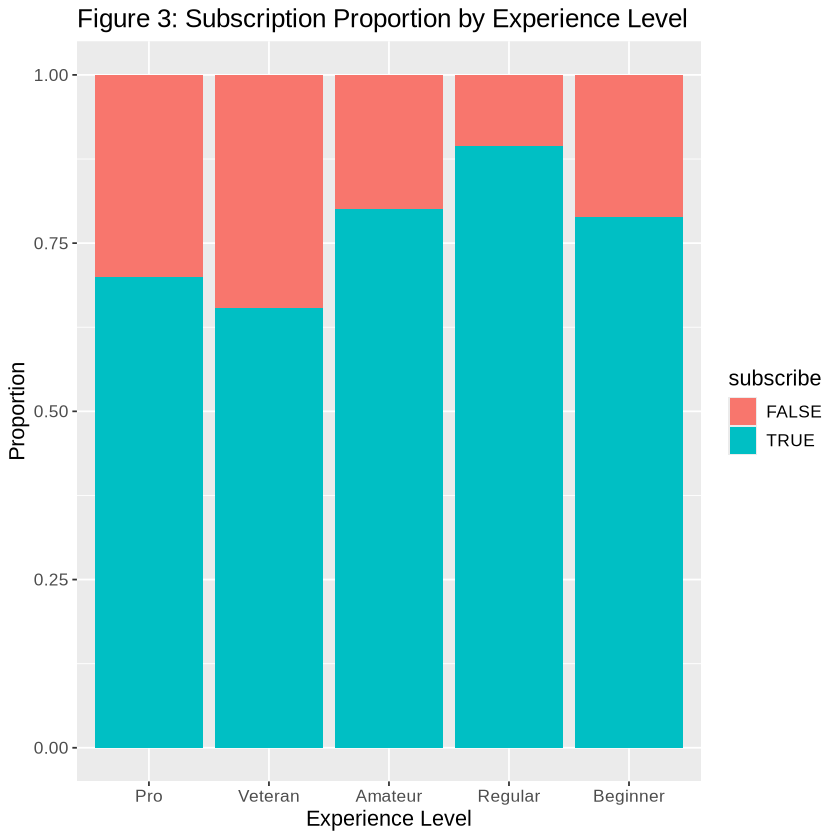

In [12]:
subscribe_experience_prop <- players_new |>
  ggplot(aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  xlab("Experience Level") +
  ylab("Proportion") +
  ggtitle("Figure 3: Subscription Proportion by Experience Level") +
  theme(text = element_text(size=13))
subscribe_experience_prop

Figure 3 shows that players at the Regular level have the highest subscription rate.

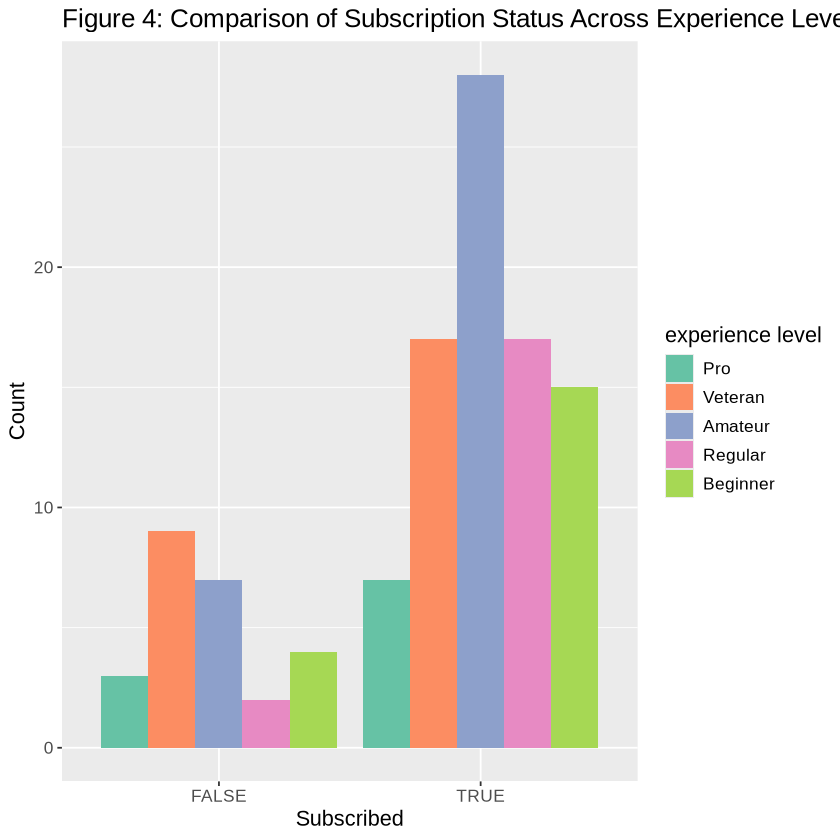

In [13]:
subscribe_experience <- ggplot(players_new, aes(x = subscribe)) + 
  geom_bar(aes(fill = experience), position = "dodge") +
  xlab("Subscribed") +
  ylab("Count") +
  scale_fill_brewer(palette = "Set2") +
  ggtitle("Figure 4: Comparison of Subscription Status Across Experience Levels") +
  labs(fill = "experience level") +
  theme(text = element_text(size=13))
subscribe_experience

Figure 4 above shows that experienced players (Veteran and Regular) have higher subscription proportions than Beginner and Pro players. It also shows that Amateur players make up most of the subscribers.

## 6. Data Preparation

In [14]:
# Apply One-Hot Encoding to convert experience into a numeric variable
encoded_experience <- model.matrix(~ experience - 1, data = players_new)

# Combine Age, subscribe, and the one-hot encoded experience variables
players_encoded <- players_new |>
  select(Age, subscribe, experience) |> 
  bind_cols(as_tibble(encoded_experience)) 
head(players_encoded)

Age,subscribe,experience,experiencePro,experienceVeteran,experienceAmateur,experienceRegular,experienceBeginner
<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,TRUE,Pro,1,0,0,0,0
17,TRUE,Veteran,0,1,0,0,0
21,TRUE,Amateur,0,0,1,0,0
21,TRUE,Regular,0,0,0,1,0
47,TRUE,Amateur,0,0,1,0,0
23,TRUE,Veteran,0,1,0,0,0


We use one hot encoding to convert `experience` from a categorical variable to a numerical variable. These transformations ensure that both variables are in suitable formats for the subsequent classification modeling process.

In [15]:
dim(players_encoded)

[1] 109   8

### Players dataset overview after encoding:
+ number of observations: 109
+ number of variables: 8

### The variables in players dataset after encoding are:
+ `experienceAmateur`, `experienceBeginner`, `experiencePro`, `experienceRegular`, and `experienceVeteran` are double variables. Each variable takes a value of 0 or 1, indicating whether the player's experience level is Amateur, Beginner, Pro, Regular, or Veteran respectively. 
+ `subscribe` is a factor variable now.
+ `Age` is an integer variable that records the player's age in years.
+ `experience` is a factor variable that records player's experience level in the game, such as `Pro`,`Veteran`, `Amateur`, `Regular`, and `Beginner`.

## 7. Data analysis

In [16]:
# Split the dataset into training and testing sets
set.seed(7654)
players_split <- initial_split(players_encoded, prop = 0.70, strata = subscribe)
players_train <- training(players_split)
players_test  <- testing(players_split)

In [17]:
# Prepares and preprocesses the data (normalization & selecting predictors)
players_recipe <- recipe(subscribe ~ Age + experienceAmateur + experienceBeginner + experiencePro + experienceRegular + experienceVeteran, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) 

players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [18]:
# Specify KNN clssification model with tunable neighbors
players_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
players_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [19]:
# Define candidate K values
players_kvalues <- tibble(neighbors = 1:25)

In [20]:
# Set up 5-fold cross-validation on training data
set.seed(7654)
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

In [21]:
# Create workflow and tune K using cross-validation
players_fit_tune <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_tune) |>
  tune_grid(resamples = players_vfold, grid = players_kvalues, control = control_grid(save_pred = TRUE))

In [22]:
# Collect accuracy results and identify best K
players_accuracy <- players_fit_tune |>
  collect_metrics() |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean))
head(players_accuracy)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,binary,0.7742857,5,0.03171642,Preprocessor1_Model06
9,accuracy,binary,0.7742857,5,0.01025193,Preprocessor1_Model09
10,accuracy,binary,0.7742857,5,0.01025193,Preprocessor1_Model10
13,accuracy,binary,0.7742857,5,0.01025193,Preprocessor1_Model13
14,accuracy,binary,0.7742857,5,0.01025193,Preprocessor1_Model14
15,accuracy,binary,0.7742857,5,0.01025193,Preprocessor1_Model15


In [23]:
# See accuracy stats with best K
best_kvalue_metrics <- players_accuracy |>
slice(1) 
best_kvalue_metrics

# Select the best K value based on accuracy
best_kvalue <- players_accuracy |>
slice(1) |> 
pull(neighbors)
best_kvalue

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,binary,0.7742857,5,0.03171642,Preprocessor1_Model06


[1] 6

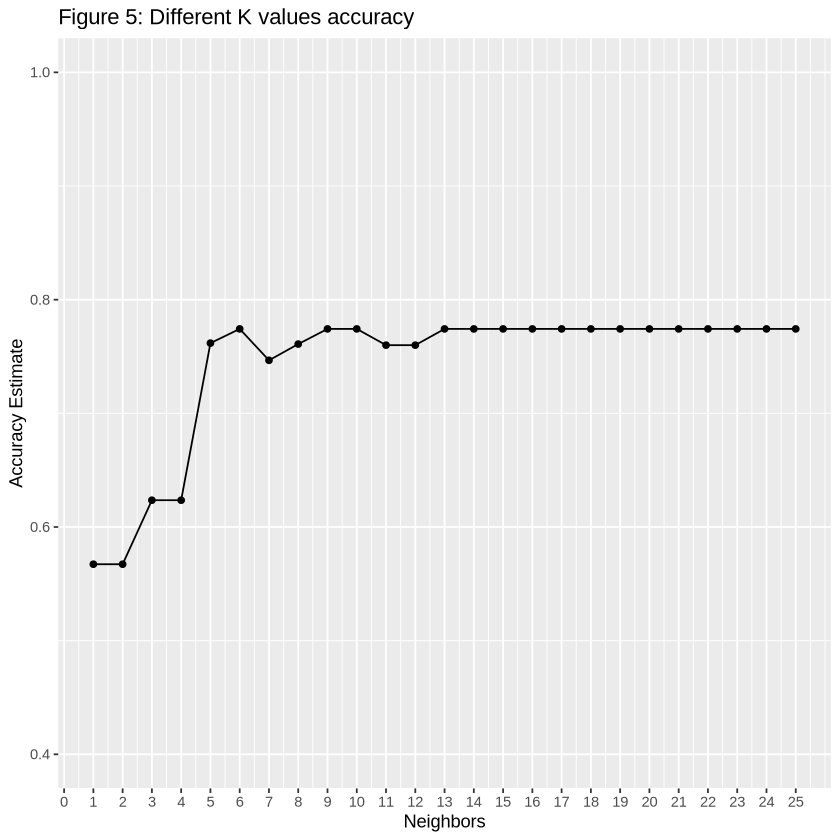

In [24]:
accuracy_versus_k <- ggplot(players_accuracy, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle("Figure 5: Different K values accuracy") +
      scale_x_continuous(breaks = seq(0, 25, by = 1)) +  
      scale_y_continuous(limits = c(0.4, 1.0))
accuracy_versus_k

In [25]:
# Train final KNN model using the best K
players_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_kvalue) |>
  set_engine("kknn") |>
  set_mode("classification")

players_workflow <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_final_spec)

players_fit <- fit(players_workflow, data = players_train)

# explain why it plateaus due to the nature of our variablbes

In [26]:
# Evaluate final KNN classification model
players_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test)

# Accuracy
players_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

# Precision
players_predictions |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "second")

# Recall
players_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "second")

players_confusion <- players_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)
players_confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7058824


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8076923


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.8076923


          Truth
Prediction FALSE TRUE
     FALSE     3    5
     TRUE      5   21

Confusion Matrix

|       | Actually Unsubscribed| Actually Subscribed |
| -------- | ------- |-------|
| Predicted Unsubscribed | 3  |  5 |
| Predicted Subscribed| 5  | 21 |

As shown in the confusion matrix, the model correctly predicted 3 non-subscribers and 21 subscribers. It misclassified 5 non-subscribers as subscribers (false positives). It also missed 5 actual subscribers by predicting them as non-subscribers (false negatives). The model tends to predict `TRUE` more often. This is likely due to the class imbalance in the `subscribe` variable, where the `TRUE` class appears much more frequently than the `FALSE` class. Given the data imbalance, precision and recall around 80.77% are acceptable and indicate the model captures most subscribers correctly. Our model's accuracy is 70.6%, meaning the model makes correct predictions about 70.6% of the time.

## Visualization of the analysis 

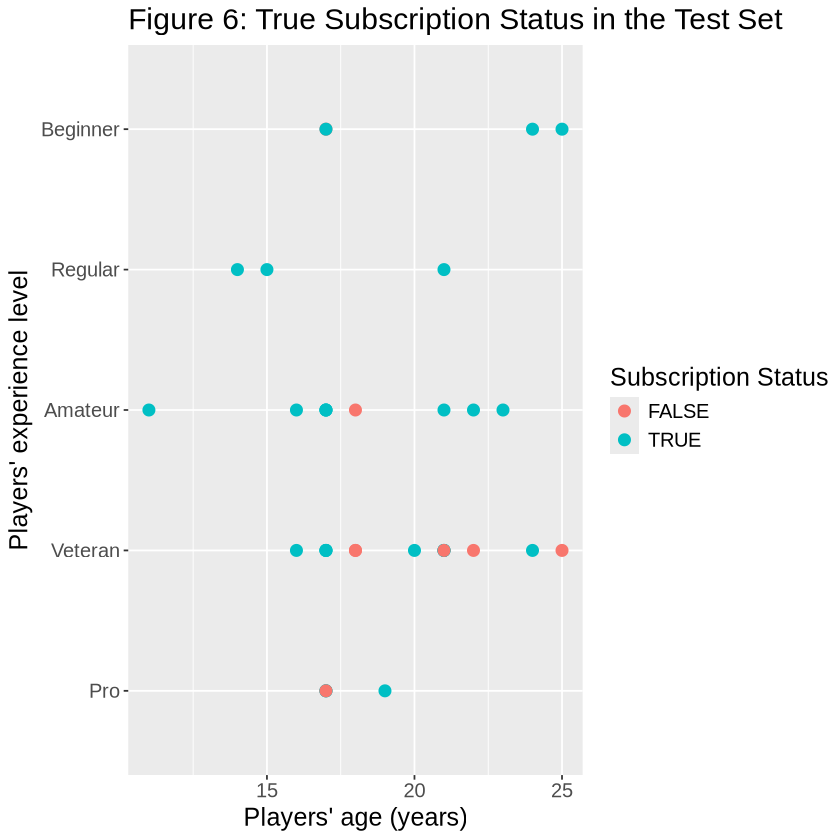

In [27]:
actual_subscribe <- ggplot(players_test, aes(x = Age, y = experience, color = subscribe)) +
  geom_point(size = 3) +
  labs(
    x = "Players' age (years)",
    y = "Players' experience level",
    title = "Figure 6: True Subscription Status in the Test Set",
    color = "Subscription Status") +
    theme(text = element_text(size = 15))
actual_subscribe

Figure 6 presents a scatter plot of the actual subscription status in the test set. Each data point represents an individual player, with color indicating their subscription status. The plot shows that subscribed players (TRUE) are noticeably more frequent than non-subscribed players (FALSE) across most age groups and experience levels, reflecting the class imbalance observed in the dataset.

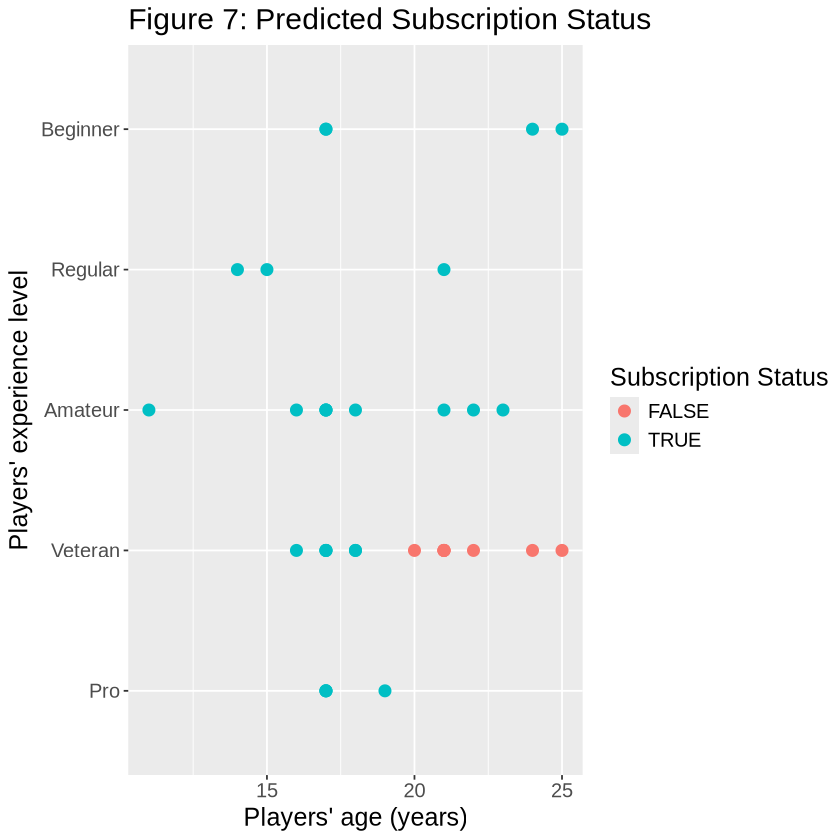

In [28]:
predicted_subscribe <- players_predictions |>
  ggplot(aes(x = Age, y = experience, color = .pred_class)) +
  geom_point(size = 3) +
  labs(
    x = "Players' age (years)",
    y = "Players' experience level",
    title = "Figure 7: Predicted Subscription Status",
    color = "Subscription Status"
  ) +
  theme(text = element_text(size = 15))
predicted_subscribe

Figure 7 shows the model's predicted subscription status for each player. We can see that many Beginner, Regular, and Amateur players are predicted to subscribe, while some Veteran players around ages 18–22 are predicted not to subscribe. Compared to Figure 6, we can observe that our model predicts players to be subscribed around ages 17, but in reality they are not subscribed. 

We create a new observation with `age` = 21 and `experience` level is Amateur and `subscribe` is TRUE, shown as the black point. We use this observation to see if our model correctly predicts this observation.

Warning message in geom_point(aes(x = 21, y = "Amateur"), color = "black", size = 5):
“All aesthetics have length 1, but the data has 34 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”


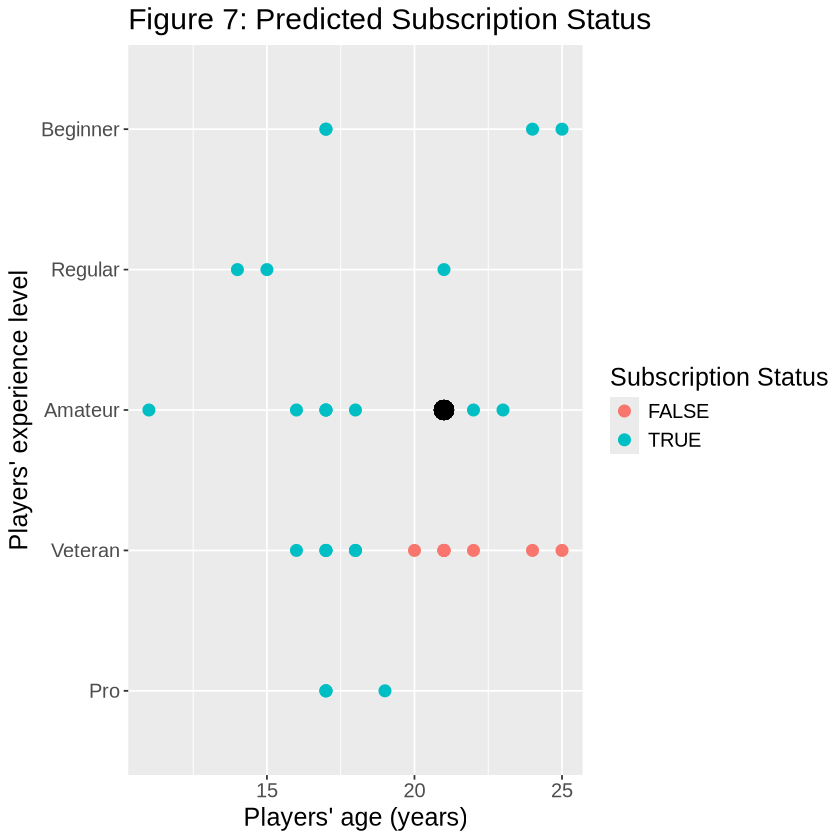

In [29]:
predicted_subscribe +
geom_point(aes(x = 21, y = "Amateur"), color = "black", size = 5)

In [30]:
new_observation <- tibble(Age = 16, experience = "Amateur",	experiencePro = 0, experienceVeteran = 0, experienceAmateur = 1, experienceRegular = 0, experienceBeginner = 0)
subscribe_prediction <- predict(players_fit, new_observation)
subscribe_prediction

.pred_class
<fct>
TRUE


Our model predict correct.

## Discussion


summarize what you found\
discuss whether this is what you expected to find\
discuss what impact could such findings have\
discuss what future questions could this lead to..

We used a K-NN classification model to see the likelihood of a player's subscription status (`subscribe`) being predicted using the player's `Age` and `experience` as predictors. The model yielded an accuracy of 70.59%, along with precision and recall values of 80.77%, indicating a reasonable ability to correctly identify subscribed players. This would be better than randomly guessing which would yield an accuracy of around 50%. Since our question is evaluating the predictive power of age and experience, accuracy would be the most valuable metric. Accuracy measures the overall proportion of correct predictions of subscribcription status, making it compprehensive indicator of model performance and enough to answer our question. While precision and recall could show our model's ability to correctly identify subscribed players or minimize false positives, our primary goal is the general predictive ability, not just one class. 

Although we got a relatively decent accuracy from our model, it is important to compare this performance to a baseline model. It was revealed in our analysis that approximately 77% of players were subscribed. A naive baseline model that predicts every player subscribes to the newsletter would have an accuracy around 77%. Our model's accuracy of 70.59% is slightly below the baseline, indicating that age and experience alone do not provide enough information to surpass the majority-class assumption. However, if we do consider the precision and recall of our model for the subscribed class ... ?

Overall, our results suggest that `Age` and `experience` could not predict... This may be due to the class imbalance.. 

Impacts:
- PLAI cannot target recruitment soley based on age and experience. 

Future questions that stem from our findings to further explore player subscriptions are:
- Would using a greater dataset change the results of our model?
- Are there other predictors such as `played_hours` that would have a greater predictive power of `subscribe`?
- Would using a different classification model other than K-NN improve the results of our model?

## References 
Pacific Laboratory of Artificial Intelligence. (2024). PLAICraft. Plaicraft.ai. https://plaicraft.ai/ \
GeeksforGeeks. (2023, August). Encoding Categorical Data in R. GeeksforGeeks. https://www.geeksforgeeks.org/r-language/encoding-categorical-data-in-r/